In [1]:
import h5py
import numpy as np

In [2]:
f5 = h5py.File("inpatient_readmission_analysis.hdf5", "r")

In [3]:
independent_array = f5["/independent/core_array"][0:10000,:]
independent_array.shape

(10000L, 5686L)

In [4]:
independent_labels = f5["/independent/column_annotations"][...]
independent_labels[0: 10]

array(['gender_concept_name|FEMALE', 'Length of stay in days',
       'age_at_visit_start_in_years_int',
       'Past history of 30-day inpatient readmissions',
       'No matching concept|0|C',
       'Gingival and periodontal disease|132344|C',
       'Staphylococcal scalded skin syndrome|132392|C',
       'Pressure ulcer stage 1|132393|C',
       'Post-laminectomy syndrome|132412|C',
       'Chronic osteomyelitis of hand|132414|C'],
      dtype='|S128')

In [5]:
dependent_array = f5["/dependent/core_array"][0:10000,:]
dependent_array = np.ndarray.flatten(dependent_array)
dependent_array.shape

(10000L,)

In [6]:
np.sum(dependent_array)

960.0

In [7]:
np.sum(independent_array)

897529

In [8]:
dependent_labels = f5["/dependent/column_annotations"][...]
dependent_labels

array(['30-day inpatient readmission'],
      dtype='|S128')

In [9]:
import sklearn
sklearn.__version__

'0.19.0'

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(independent_array, dependent_array, test_size=0.2)

In [12]:
X_test

array([[84,  6,  0, ...,  0,  0,  0],
       [55,  7,  0, ...,  0,  0,  0],
       [48,  3,  1, ...,  0,  0,  0],
       ..., 
       [84,  5,  1, ...,  0,  0,  0],
       [68,  8,  0, ...,  0,  0,  0],
       [67,  6,  0, ...,  0,  0,  0]])

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier

In [15]:
variance_thresh = VarianceThreshold()
select_k = SelectKBest(k=1000)
random_forest = RandomForestClassifier(n_estimators=1000)

pipeline_steps = [("remove_zero_variance", variance_thresh), 
                  ("select_features", select_k), 
                  ("random_forest", random_forest)]

In [16]:
pipeline_obj = Pipeline(pipeline_steps)

In [17]:
pipeline_obj.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('remove_zero_variance', VarianceThreshold(threshold=0.0)), ('select_features', SelectKBest(k=1000, score_func=<function f_classif at 0x0000000014B5D128>)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [18]:
Y_predict = pipeline_obj.predict(X_test)
Y_predict[0: 100]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [19]:
from sklearn.metrics import classification_report

In [20]:
report = classification_report(Y_predict, Y_test)

In [21]:
print(report)

             precision    recall  f1-score   support

        0.0       0.99      0.90      0.94      1986
        1.0       0.01      0.07      0.01        14

avg / total       0.99      0.90      0.94      2000



In [22]:
from sklearn.metrics import roc_curve

In [23]:
Y_test_p = pipeline_obj.predict_proba(X_test)
Y_test_p[0: 10]

array([[ 0.962     ,  0.038     ],
       [ 0.975     ,  0.025     ],
       [ 0.982     ,  0.018     ],
       [ 0.94925   ,  0.05075   ],
       [ 0.997     ,  0.003     ],
       [ 0.991     ,  0.009     ],
       [ 0.996     ,  0.004     ],
       [ 0.95019527,  0.04980473],
       [ 0.964     ,  0.036     ],
       [ 0.905     ,  0.095     ]])

In [24]:
import matplotlib.pyplot as plt
import seaborn as sb

In [25]:
fpr, tpr, _ = roc_curve(Y_test, Y_test_p[:,1])

In [26]:
%matplotlib inline

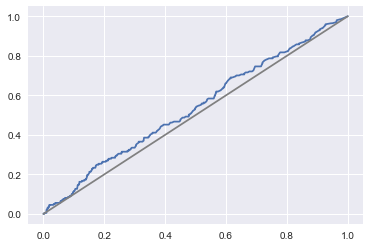

In [27]:
sb.set_style("darkgrid")
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "k-", color="grey")

In [28]:
from sklearn.metrics import roc_auc_score

In [29]:
roc_auc_score(Y_test, Y_test_p[:,1])

0.53588069517527193

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
confusion_matrix(Y_test, Y_predict)

array([[1790,   13],
       [ 196,    1]], dtype=int64)

In [32]:
variance_thresh.get_support()

array([ True,  True,  True, ..., False,  True, False], dtype=bool)

In [33]:
selected_variables1 = independent_labels[variance_thresh.get_support()]

In [34]:
select_k.get_support().shape

(3257L,)

In [35]:
selected_variables2 = selected_variables1[select_k.get_support()]

In [36]:
selected_variables2.shape

(1000L,)

In [37]:
features_importances = random_forest.feature_importances_

In [38]:
random_forest.feature_importances_.shape

(1000L,)

In [39]:
import numpy as np

In [40]:
decreasing_order_of_features = np.argsort(-1*random_forest.feature_importances_,)

In [41]:
[(selected_variables2[decreasing_order_of_features][i], features_importances[decreasing_order_of_features][i]) 
 for i in range(features_importances.shape[0])]

[('Length of stay in days', 0.071519542991589094),
 ('History of clinical finding in subject|4214956|M', 0.017046670749470593),
 ('Coronary arteriosclerosis in native artery|42872402|C',
  0.015162890869780414),
 ('Atrial fibrillation|313217|C', 0.014977693480529327),
 ('Urinary tract infectious disease|81902|C', 0.014710580522327486),
 ('Hypertensive renal disease with renal failure|439697|C',
  0.012656824269194514),
 ('Hypothyroidism|140673|C', 0.012341292408396438),
 ('Other repair of urethra|2003877|P', 0.010326326585340179),
 ('Tobacco dependence syndrome|437264|C', 0.0097254542282811871),
 ('Pure hypercholesterolemia|437827|C', 0.0086698703996323737),
 ('Temporary tracheostomy|2001285|P', 0.0086087379893359829),
 ('Hypokalemia|437833|C', 0.0085084202294153609),
 ('Dehydration|435796|C', 0.0084938730835713971),
 ('Osteoarthritis|80180|C', 0.0081903096652032274),
 ('Organic mental disorder|374009|C', 0.0081027154018250107),
 ('Suture of laceration of palate|2001220|P', 0.007964914